In [1]:
import sys
sys.path.insert(0, '../src')

import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from carpediem import data as cd_data

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
pd.options.display.max_columns = 300
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 10000

In [4]:
data = pd.read_csv(
    cd_data.materials.general['03_counting']['03_counting_with_BAL'].path, 
    index_col=0
)

/Users/mxposed/Documents/Northwestern/cereal/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10,77,78,79,80,81,82,83,130,131,132,133,137,138,140,143,152,154,156,157,158,159,160,161,162,169,171,192,199,206,223,227,228,229,230,231,233,234,235,236,237,253,254,255,265,289,291,292,293,294) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Single-cell pathogen pre-analysis

Rename some

In [25]:
PATHOGEN_NAMES = {
    'Viridans Streptococcus': 'Viridans streptococcus',
    'enterobacter cloacae complex': 'Enterobacter cloacae complex',
    'escherichia coli': 'Escherichia coli',
    'haemophilus influenzae': 'Haemophilus influenzae',
    'klebsiella aerogenes': 'Klebsiella aerogenes',
    'klebsiella oxytoca': 'Klebsiella oxytoca',
    'klebsiella pneumoniae group': 'Klebsiella pneumoniae group',
    'proteus spp': 'Proteus spp',
    'pseudomonas aeruginosa': 'Pseudomonas aeruginosa',
    'serratia marcescens': 'Serratia marcescens',
    'staphylococcus aureus': 'Staphylococcus aureus',
    'streptococcus agalactiae': 'Streptococcus agalactiae',
    'streptococcus pneumoniae': 'Streptococcus pneumoniae',
    'covid_19': 'SARS-CoV-2'
}

## 1. Filtering pathogens for each sample:

1. From PCR we take all viruses and bacteria
2. From Culture we take bacteria if their CFU >= 10000
3. We ignore Fungal results
4. We remove duplicates among them

In [64]:
def expand_pathogens(val):
    if not isinstance(val, str):
        return {}
    pathogens = set()
    val = json.loads(val)
    if 'virus' in val['pcr']:
        pathogens |= set(val['pcr']['virus'])
    if 'bacteria' in val['pcr']:
        pathogens |= set(val['pcr']['bacteria'])
    for p in val['culture']:
        if p['cfu'] >= 10000:
            pathogens.add(p['name'])
    return {PATHOGEN_NAMES.get(x, x): True for x in pathogens}
pathogens = pd.DataFrame(
    data.pathogen_results[data.Sc_GEX_available.fillna(False)].apply(expand_pathogens).tolist()
).fillna(False)

In [69]:
pathogens.shape

(272, 34)

This gives us 34 pathogens

## 2. Count samples for each combination of pathogens

In [63]:
def list_pathogens(row):
    count = row['count']
    row = row.drop('count')
    return pd.Series([','.join(row.index[row]), count], index=['pathogens', 'count'])
pathogens.value_counts().reset_index(name='count').apply(list_pathogens, axis=1)

,pathogens,count
0,,93
1,SARS-CoV-2,76
2,Pseudomonas aeruginosa,12
3,Staphylococcus aureus,10
4,"SARS-CoV-2,Staphylococcus aureus",9
5,"SARS-CoV-2,Pseudomonas aeruginosa",9
6,Klebsiella pneumoniae group,4
7,Klebsiella aerogenes,3
8,"Klebsiella pneumoniae group,Klebsiella pneumoniae",2
9,Staphylococcus coagulase negative,2


Some pathogens could potentially be merged (i.e. `Klebsiella pneumoniae group,Klebsiella pneumoniae`)

Also we can group pathogens by species, gram-positive/negative or just virus/bacteria categories

**Conclusion**: beyond first 5 pathogen groups, sample size is really small (<5 samples)

## 3. Number of pathogens per sample

In [68]:
pathogens.sum(axis=1).value_counts().sort_index()

0     90
1    116
2     48
3     12
4      5
5      1
dtype: int64

## 4. Cluster map of pathogen binary vectors

Especially for Marcin!

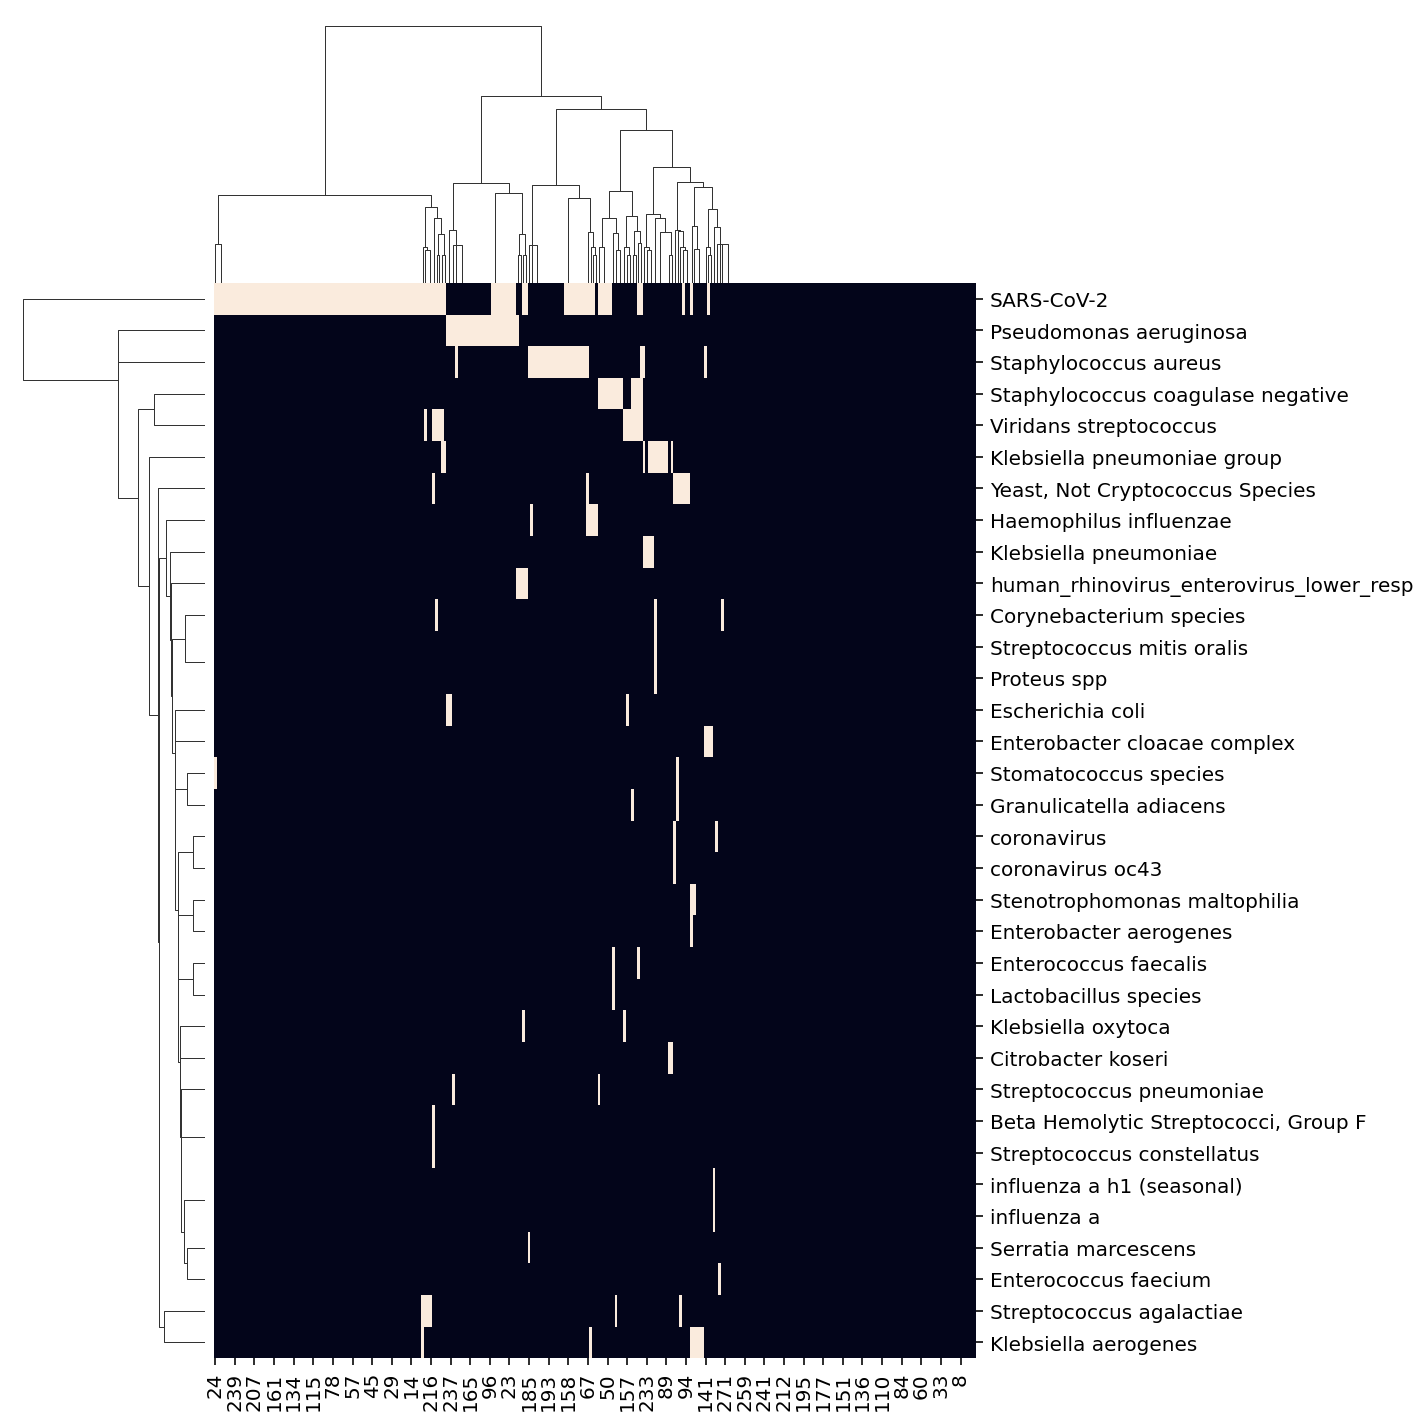

In [66]:
sns.clustermap(
    pathogens.T,
    method='ward',
    cbar_pos=None
)